<a href="https://colab.research.google.com/github/glorivaas/Machine_Learning25/blob/main/Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3 - Linear and Logistic Regression
### Author: Gloria Rivas



---
## **TESTING DIFFERENT THESHOLDS**
**Is a 0.5 threshold always the best choice in Logistic Regression?**


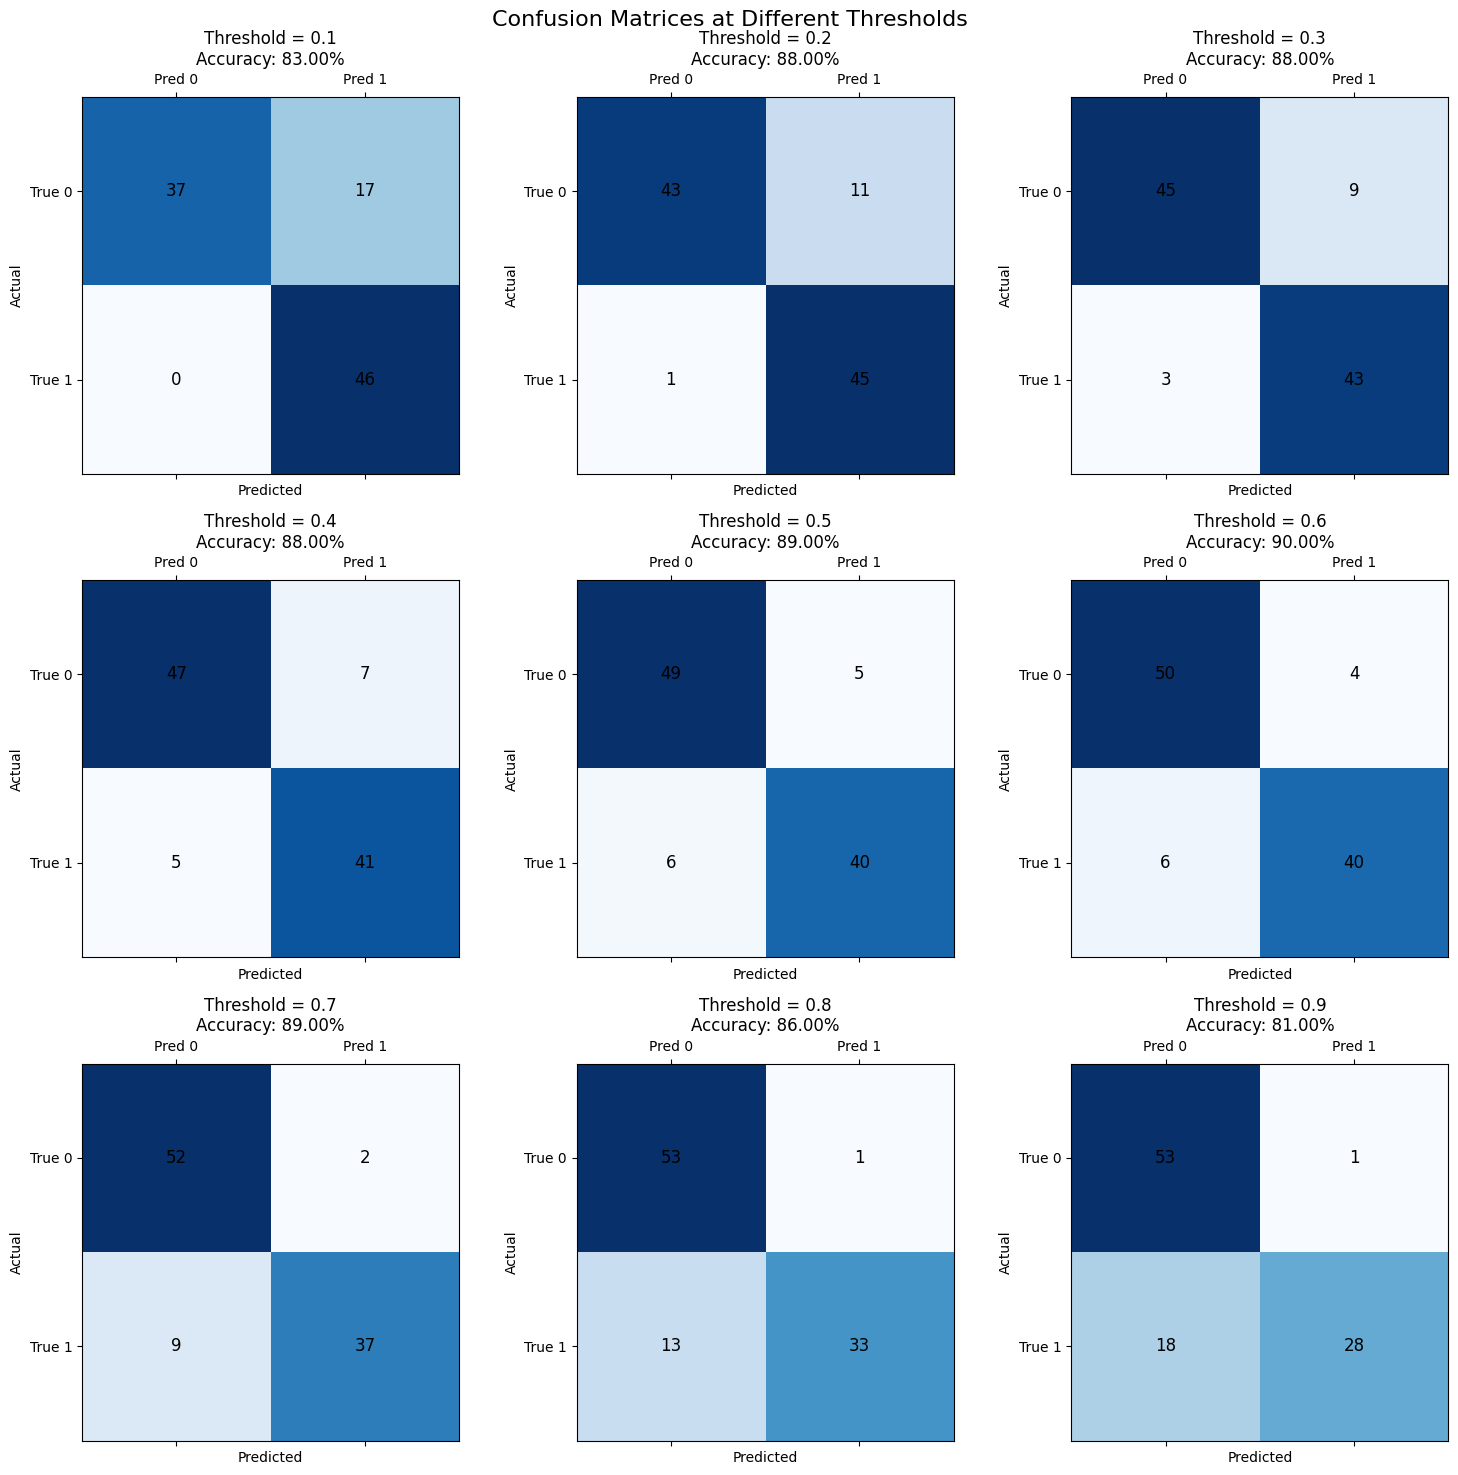

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

np.random.seed(42)
beta_0 = -1
beta_1 = 2

X = np.linspace(-3, 3, 500).reshape(-1, 1)

logit = beta_0 + beta_1 * X.flatten()
probabilities = 1 / (1 + np.exp(-logit))

y = np.random.binomial(1, probabilities)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

y_pred_prob = logistic_model.predict_proba(X_test)[:, 1]
y_val_prob = logistic_model.predict_proba(X_val)[:, 1]
y_val_pred = logistic_model.predict(X_val)

thresholds = np.linspace(0.1, 0.9, 9)
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.ravel()

for i, thresh in enumerate(thresholds):
    y_pred = (y_pred_prob >= thresh).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred) * 100

    ax = axes[i]
    im = ax.matshow(cm, cmap='Blues')
    ax.set_title(f"Threshold = {thresh:.1f}\nAccuracy: {accuracy:.2f}%")
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["Pred 0", "Pred 1"])
    ax.set_yticklabels(["True 0", "True 1"])
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

    for j in range(2):
        for k in range(2):
            ax.text(k, j, cm[j, k], ha='center', va='center', color='black', fontsize=12)

plt.suptitle("Confusion Matrices at Different Thresholds", fontsize=16)
plt.tight_layout()
plt.show()



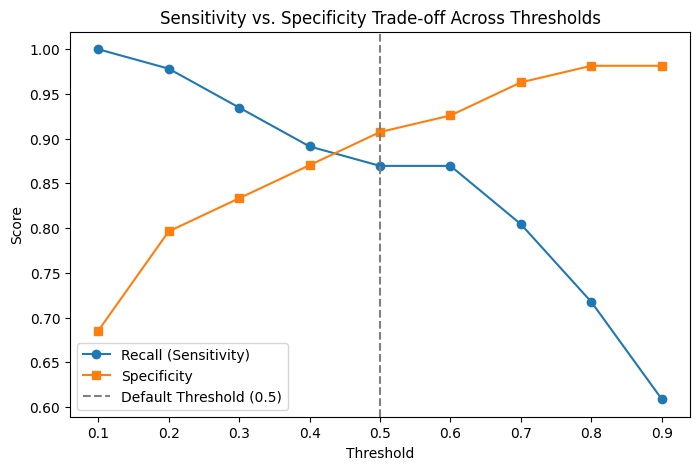

In [30]:
specificity_vals = []
threshold_results = []
thresholds = np.linspace(0.1, 0.9, 9)

for thresh in thresholds:
    y_pred = (y_pred_prob >= thresh).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0

    specificity_vals.append(specificity)
    threshold_results.append([thresh, precision, recall, specificity, f1])

threshold_df = pd.DataFrame(threshold_results, columns=["Threshold", "Precision", "Recall (Sensitivity)", "Specificity", "F1-Score"])

recall_vals = threshold_df["Recall (Sensitivity)"].tolist()
specificity_vals = threshold_df["Specificity"].tolist()

plt.figure(figsize=(8, 5))
plt.plot(thresholds, recall_vals, label="Recall (Sensitivity)", marker='o', linestyle='-')
plt.plot(thresholds, specificity_vals, label="Specificity", marker='s', linestyle='-')
plt.axvline(0.5, color='gray', linestyle='--', label="Default Threshold (0.5)")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Sensitivity vs. Specificity Trade-off Across Thresholds")
plt.legend()
plt.show()


#Observations

Let´s start with some definitions in order to understand better the graph:

- **Sensitivity** (Recall or True Positive Rate - TPR): measures how well the model identifies actual positives.
$$
\text{Sensitivity} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Negatives (FN)}}
$$
-**Specificity** (True Negative Rate - TNR): measures how well the model identifies actual negatives.
$$
\text{Specificity} = \frac{\text{True Negatives (TN)}}{\text{True Negatives (TN)} + \text{False Positives (FP)}}
$$
<br>
1.  **Lower Thresholds (0.1 - 0.3)**
<br>The model classifies more observations as positive, resulting in fewer false negatives. However, this increases false positives, meaning more negatives are misclassified as positives.
<br>This is suitable for scenarios where missing a positive case is costly, such as disease detection or fraud detection.

2. **Middle Thresholds (0.4 - 0.6)**
<br>The model maintains a balance between false positives and false negatives. For instance, at threshold = 0.5 we have 5 false positives and 6 false negatives, so precision and recall are similar.
This is the default setting and works well when precision and recall are equally important.
<br>This is a good situation for general cases like spam filtering.

3. **Higher Thresholds (0.7 - 0.9)**
<br>The model is more selective in predicting positives, reducing false positives.
Nevertheless, false negatives increase, meaning more actual positives are misclassified as negatives. For example, at threshold = 0.9, there are only 1 false positive, but 19 false negatives.
This means specificity is high, but recall is low.
<br>This is optimal in situations where false positives are costly, such as criminal justice decisions or autonomous vehicle safety.

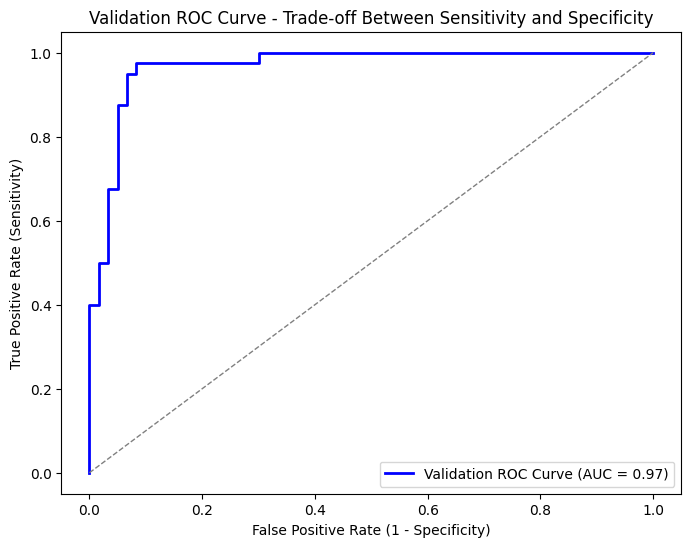

Optimal Threshold based on Validation Set: 0.25

Final Model Performance on Test Set:
Accuracy: 90.00%
Precision: 0.83
Recall (Sensitivity): 0.98
F1-Score: 0.90
Specificity: 0.83


In [26]:
fpr_val, tpr_val, roc_thresholds_val = roc_curve(y_val, y_val_prob)
roc_auc_val = auc(fpr_val, tpr_val)

plt.figure(figsize=(8, 6))
plt.plot(fpr_val, tpr_val, color='blue', lw=2, label=f'Validation ROC Curve (AUC = {roc_auc_val:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("Validation ROC Curve - Trade-off Between Sensitivity and Specificity")
plt.legend()
plt.show()

j_scores_val = tpr_val - fpr_val
best_index_val = np.argmax(j_scores_val)
best_threshold = roc_thresholds_val[best_index_val]

print(f"Optimal Threshold based on Validation Set: {best_threshold:.2f}")

#Apply to the test set
y_test_prob = logistic_model.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_prob >= best_threshold).astype(int)

accuracy = accuracy_score(y_test, y_test_pred) * 100
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_test_pred, average='binary')
cm_test = confusion_matrix(y_test, y_test_pred)
tn, fp, fn, tp = cm_test.ravel()
specificity = tn / (tn + fp) if (tn + fp) != 0 else 0  # Avoid division by zero

print("\nFinal Model Performance on Test Set:")
print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall (Sensitivity): {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"Specificity: {specificity:.2f}")


- **How does a ROC curve help in this process?**
<br>The Receiver Operating Characteristic (ROC) curve helps visualize the trade-off between $Sensitivity$ (True Positive Rate) and$ 1 - Specificity$ (False Positive Rate) at different classification thresholds.
<br>The X-axis represents $(1 - Specificity)$ and the Y-axis represents $Sensitivity$. The blue line represents model performance at various thresholds. The dashed diagonal line represents random guessing (AUC = 0.5), meaning a model should perform above this line.

- **How to use a ROC curve for threshold selection?**
<br>Look for the "elbow point" in the ROC curve, where Sensitivity is high and False Positives are low.
Compute Youden’s J statistic:
$$J= Sensitivity + Specificity−1$$
The optimal threshold is where
J is maximized. In our case, the best threshold is approximately 0.25.

- **What is the AUC metric and how is it useful?**
<br>AUC (Area Under the Curve) is a metric that quantifies the overall performance of a binary classifier. It is derived from the ROC curve.
AUC represents the probability that the classifier ranks a randomly chosen positive instance higher than a randomly chosen negative instance. For interpreting this metrics, we can say that a AUC > 0.9 means an excellent model (highly effective classification), while a AUC < 0.5 is worse than random (the model is misclassifying). Some benefits of the AUC is that it is robust, threshold independent, and ideal for imbalanced data problems.
<br> In our case, the computed AUC = 0.97 means that the model has an excellent discrimination ability between positive and negative classes.

#**CONCLUSION** (Answer to the main question)
In logistic regression, the default classification threshold of 0.5 is commonly used to distinguish between positive and negative classes. This is due to the fact that it usually provides a good balance between false negatives and false positives. <br>However, our analysis demonstrates that this threshold is not always the optimal choice and should be adjusted based on the specific problem and evaluation criteria.

In our case, we have a low threshold (0.25) meaning that the model is more likely to classify instances as positive, increasing sensitivity to 98% (almost all actual positives are correctly identified). Nevertheless, specificity is lower (83%), so we can expect some false positives to occur. Overall, 90% accuracy indicates that the model is classifying most cases correctly. Futhermore, since F1-score is the harmonic mean of Precision & Recall, a high value (0.90) confirms the model maintains a good trade-off.